In [111]:
import os
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

import logging

logger = logging.getLogger(__name__)

In [51]:
def assign_location(n):
    for c in n.iterate_components(n.one_port_components | n.branch_components):
        ifind = pd.Series(c.df.index.str.find(" ", start=4), c.df.index)
        for i in ifind.value_counts().index:
            # these have already been assigned defaults
            if i == -1:
                continue
            names = ifind.index[ifind == i]
            c.df.loc[names, "location"] = names.str[:i]

In [97]:
# read tech colors (yaml file) as dict
import yaml
with open('../scripts/tech_colors.yaml') as file:
    tech_colors = yaml.load(file, Loader=yaml.FullLoader)["tech_colors"]

tech_colors["LDES"] = "magenta"

In [2]:
fs = 15
plt.style.use('seaborn-ticks')
plt.rcParams['axes.labelsize'] = fs
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['hatch.color'] = "lightgrey"

In [3]:
path = "C:\\Users/au485969/OneDrive - Aarhus universitet/PhD/IIASA YSSP/pypsa/networks/new_SDES_LDES_co2_lim/"

In [4]:
os.path.isdir(path)

True

In [104]:
# n = pypsa.Network(path + "elec_s370_37_lv1.0__Co2L0.05-1H-solar+p3-dist1-sharesolar+0.1-sharewind+0.1-greenfield-LDES_2030.nc")
n = pypsa.Network(path + "elec_s370_37_lv1.0__Co2L0.05-1H-solar+p3-dist1-sharesolar+0.4-sharewind+0.6-greenfield-LDES_2030.nc")
# n = pypsa.Network(path + "elec_s370_37_lv1.0__Co2L0.05-1H-solar+p3-dist1-sharesolar+0.1-sharewind+0.3-greenfield-LDES_2030.nc")

INFO:pypsa.io:Imported network elec_s370_37_lv1.0__Co2L0.05-1H-solar+p3-dist1-sharesolar+0.4-sharewind+0.6-greenfield-LDES_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


In [105]:
# drop buses that do not have "AC" as carrier
n_plot = n.copy()

assign_location(n_plot)

n_plot.buses.drop(n_plot.buses.index[n_plot.buses.carrier != "AC"], inplace=True)

# n_plot.buses = n_plot.buses[n.buses.carrier == "AC"]
# n.lines = n.lines[n.lines.carrier == "AC"]
# n.generators = n.generators[n.generators.carrier == "AC"]
n_plot.storage_units = n_plot.storage_units[n.storage_units.carrier == "AC"]
n_plot.links = n_plot.links[n_plot.links.carrier == "DC"]



In [28]:
def rename_techs(label):
    prefix_to_remove = [
        "residential ",
        "services ",
        "urban ",
        "rural ",
        "central ",
        "decentral ",
    ]

    rename_if_contains = [
        "CHP",
        "gas boiler",
        "biogas",
        "solar thermal",
        "air heat pump",
        "ground heat pump",
        "resistive heater",
        "Fischer-Tropsch",
    ]

    rename_if_contains_dict = {
        "water tanks": "hot water storage",
        "retrofitting": "building retrofitting",
        # "H2 Electrolysis": "hydrogen storage",
        # "H2 Fuel Cell": "hydrogen storage",
        # "H2 pipeline": "hydrogen storage",
        "battery": "battery storage",
        "H2 for industry": "H2 for industry",
        "land transport fuel cell": "land transport fuel cell",
        "land transport oil": "land transport oil",
        "oil shipping": "shipping oil",
        # "CC": "CC"
    }

    rename = {
        "solar": "solar PV",
        "Sabatier": "methanation",
        "offwind": "offshore wind",
        "offwind-ac": "offshore wind (AC)",
        "offwind-dc": "offshore wind (DC)",
        "onwind": "onshore wind",
        "ror": "hydroelectricity",
        "hydro": "hydroelectricity",
        "PHS": "hydroelectricity",
        "NH3": "ammonia",
        "co2 Store": "DAC",
        "co2 stored": "CO2 sequestration",
        "AC": "transmission lines",
        "DC": "transmission lines",
        "B2B": "transmission lines",
    }

    for ptr in prefix_to_remove:
        if label[: len(ptr)] == ptr:
            label = label[len(ptr) :]

    for rif in rename_if_contains:
        if rif in label:
            label = rif

    for old, new in rename_if_contains_dict.items():
        if old in label:
            label = new

    for old, new in rename.items():
        if old == label:
            label = new
    return label

In [29]:
def rename_techs_tyndp(tech):
    tech = rename_techs(tech)
    if "heat pump" in tech or "resistive heater" in tech:
        return "power-to-heat"
    elif tech in ["H2 Electrolysis", "methanation", "helmeth", "H2 liquefaction"]:
        return "power-to-gas"
    elif tech == "H2":
        return "H2 storage"
    elif tech in ["NH3", "Haber-Bosch", "ammonia cracker", "ammonia store"]:
        return "ammonia"
    elif tech in ["OCGT", "CHP", "gas boiler", "H2 Fuel Cell"]:
        return "gas-to-power/heat"
    # elif "solar" in tech:
    #     return "solar"
    elif tech in ["Fischer-Tropsch", "methanolisation"]:
        return "power-to-liquid"
    elif "offshore wind" in tech:
        return "offshore wind"
    elif "CC" in tech or "sequestration" in tech:
        return "CCS"
    else:
        return tech

In [33]:
preferred_order = pd.Index(
    [
        "transmission lines",
        "hydroelectricity",
        "hydro reservoir",
        "run of river",
        "pumped hydro storage",
        "solid biomass",
        "biogas",
        "onshore wind",
        "offshore wind",
        "offshore wind (AC)",
        "offshore wind (DC)",
        "solar PV",
        "solar thermal",
        "solar rooftop",
        "solar",
        "building retrofitting",
        "ground heat pump",
        "air heat pump",
        "heat pump",
        "resistive heater",
        "power-to-heat",
        "gas-to-power/heat",
        "CHP",
        "OCGT",
        "gas boiler",
        "gas",
        "natural gas",
        "helmeth",
        "methanation",
        "ammonia",
        "hydrogen storage",
        "power-to-gas",
        "power-to-liquid",
        "battery storage",
        "hot water storage",
        "CO2 sequestration",
    ]
)

In [109]:
costs = pd.DataFrame(index=n_plot.buses.index)

for comp in ["generators","stores","links","storage_units"]:
    df_c = getattr(n_plot, comp)

    if df_c.empty:
        continue

    df_c["nice_group"] = df_c.carrier.map(rename_techs_tyndp)

    attr = "e_nom_opt" if comp == "stores" else "p_nom_opt"

    costs_c = (
        (df_c.capital_cost * df_c[attr])
        .groupby([df_c.location, df_c.nice_group])
        .sum()
        .unstack()
        .fillna(0.0)
    )
    costs = pd.concat([costs, costs_c], axis=1)

    logger.debug(f"{comp}, {costs}")

costs = costs.groupby(costs.columns, axis=1).sum()

costs.drop(list(costs.columns[(costs == 0.0).all()]), axis=1, inplace=True)

new_columns = preferred_order.intersection(costs.columns).append(
    costs.columns.difference(preferred_order)
)
costs = costs[new_columns]

for item in new_columns:
    if item not in tech_colors:
        logger.warning(f"{item} not in tech_colors")

costs = costs.stack()  # .sort_index()

to_drop = costs.index.levels[0].symmetric_difference(n.buses.index)
if len(to_drop) != 0:
    logger.info(f"Dropping non-buses {to_drop.tolist()}")
    costs.drop(to_drop, level=0, inplace=True, axis=0, errors="ignore")

costs.drop('EU gas', level=0, inplace=True, axis=0, errors="ignore")
costs.drop('EU uranium', level=0, inplace=True, axis=0, errors="ignore")

# make sure they are removed from index
costs.index = pd.MultiIndex.from_tuples(costs.index.values)

threshold = 100e6  # 100 mEUR/a
carriers = costs.groupby(level=1).sum()
carriers = carriers.where(carriers > threshold).dropna()
carriers = list(carriers.index)

# PDF has minimum width, so set these to zero
line_lower_threshold = 500.0
line_upper_threshold = 1e4
linewidth_factor = 4e3
ac_color = "rosybrown"
dc_color = "darkseagreen"


INFO:__main__:Dropping non-buses ['AL0 0 H2', 'AL0 0 LDES', 'AL0 0 battery', 'AL0 0 home battery', 'AL0 0 low voltage', 'AT0 0 H2', 'AT0 0 LDES', 'AT0 0 battery', 'AT0 0 home battery', 'AT0 0 low voltage', 'BA0 0 H2', 'BA0 0 LDES', 'BA0 0 battery', 'BA0 0 home battery', 'BA0 0 low voltage', 'BE0 0 H2', 'BE0 0 LDES', 'BE0 0 battery', 'BE0 0 home battery', 'BE0 0 low voltage', 'BG0 0 H2', 'BG0 0 LDES', 'BG0 0 battery', 'BG0 0 home battery', 'BG0 0 low voltage', 'CH0 0 H2', 'CH0 0 LDES', 'CH0 0 battery', 'CH0 0 home battery', 'CH0 0 low voltage', 'CZ0 0 H2', 'CZ0 0 LDES', 'CZ0 0 battery', 'CZ0 0 home battery', 'CZ0 0 low voltage', 'DE0 0 H2', 'DE0 0 LDES', 'DE0 0 battery', 'DE0 0 home battery', 'DE0 0 low voltage', 'DK0 0 H2', 'DK0 0 LDES', 'DK0 0 battery', 'DK0 0 home battery', 'DK0 0 low voltage', 'DK1 0 H2', 'DK1 0 LDES', 'DK1 0 battery', 'DK1 0 home battery', 'DK1 0 low voltage', 'EE2 0 H2', 'EE2 0 LDES', 'EE2 0 battery', 'EE2 0 home battery', 'EE2 0 low voltage', 'ES0 0 H2', 'ES0 0 L

c:\Users\au485969\Anaconda3\envs\pypsa-eur\lib\site-packages\cartopy\mpl\style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



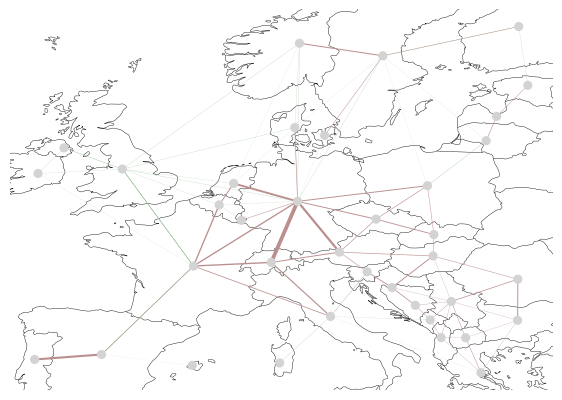

In [131]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.EqualEarth(), })
fig.set_size_inches(7, 6)

plt.axis('off')

linewidth_factor = 1e4
bus_size_factor = 1e10
# fig, ax = plt.subplots()
n_plot.plot(bus_sizes=0.1, #costs / bus_size_factor,
            bus_colors="lightgrey",
            # line_colors=ac_color,
            # link_colors=dc_color,
            line_widths=n_plot.lines.s_nom / linewidth_factor,
            link_widths=n_plot.links.p_nom / linewidth_factor,
            # ax=ax
            )

fig.savefig("network_empty.png", dpi=300, bbox_inches="tight")

c:\Users\au485969\Anaconda3\envs\pypsa-eur\lib\site-packages\cartopy\mpl\style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



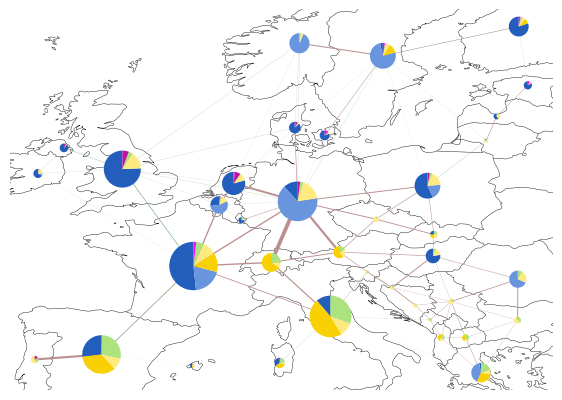

In [132]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.EqualEarth()})
fig.set_size_inches(7, 6)

plt.axis('off')

linewidth_factor = 1e4
bus_size_factor = 1e10
# fig, ax = plt.subplots()
n_plot.plot(bus_sizes=costs / bus_size_factor,
        bus_colors=tech_colors,
        # line_colors=ac_color,
        # link_colors=dc_color,
        line_widths=n_plot.lines.s_nom / linewidth_factor,
        link_widths=n_plot.links.p_nom / linewidth_factor,
        # ax=ax
        )

fig.savefig("network_w_capacity.png", dpi=300, bbox_inches="tight")

In [107]:
def calculate_storage_cycles(n,tech):
    stores = n.stores.loc[n.stores.carrier.str.contains(tech)].index
    if len(stores) == 0:
        return 0, 0
    
    soc = n.stores_t.e[stores].sum(axis=1)
    soc_diff = soc.diff()
    soc_diff[soc_diff < 0] = 0 # negative changes (discharging) get 0 values
    soc_diff[soc_diff > 0] = 1 # positive changes (charging) get 1 values
    soc_diff_diff = soc_diff.diff()

    # calculate average depth of discharge
    cycle_index_1 = soc_diff_diff[soc_diff_diff > 0].index
    cycle_index_2 = soc_diff_diff[soc_diff_diff < 0].index

    if len(cycle_index_2) > len(cycle_index_1):
        cycle_index_2 = cycle_index_2[:-1]
    elif len(cycle_index_2) < len(cycle_index_1):
        cycle_index_1 = cycle_index_1[:-1]

    dod = ((soc.loc[cycle_index_2].values - soc.loc[cycle_index_1])/(soc.max())*100) # depth of discharge for each cycle
    dod = dod[dod >= 5] # neglect cycles with DOD < 5% of the maximum SOC
    
    no_cycles = len(dod) # number of cycles
    dod_mean = dod.mean() # average depth of discharge

    return no_cycles, dod_mean

def calculate_aggregated_storage_cost(n,tech,costs, efficiencies):
    stores = n.stores.loc[n.stores.carrier.str.contains(tech)].index
    if len(stores) == 0:
        return 0, 0

    discharger_links = n.links.loc[n.links.carrier.str.contains(tech + " discharger")].index 
    eta_c = efficiencies["charging"] # 
    eta_d = efficiencies["discharging"] #
    efficiency = eta_c*eta_d # round-trip efficiency
    c_c = costs["charging"] # 
    c_hat = costs["storage"] # 
    c_d = costs["discharging"] #

    energy_cap = n.stores.loc[stores].e_nom_opt
    power_cap = n.links.loc[discharger_links].p_nom_opt

    # divide energy cap with power cap to get duration (ignore index):
    duration = (energy_cap.values/power_cap.values).mean()
    # duration = energy_cap.sum()/power_cap.sum()

    inv_cost = 1/efficiency*c_c + duration*c_hat + c_d

    return duration, inv_cost

def calculate_storage_capacity_factor(n,tech):
    stores = n.stores.loc[n.stores.carrier.str.contains(tech)].index
    if len(stores) == 0:
        return 0

    discharger_links = n.links.loc[n.links.carrier.str.contains(tech + " discharger")].index # links
    efficiency = n.links.loc[discharger_links].efficiency.values[0] # discharging efficiency
    dispatch_t = -n.links_t.p1[discharger_links] # dispatch [MWh of electricity delivered]
    dispatch_t[dispatch_t < 0.1] = 0 # neglect small discharging values
    capacity = n.links.loc[discharger_links].p_nom_opt*efficiency # capacity [MW of electricity delivered]

    capacity_factor_t = dispatch_t.sum(axis=1)/capacity.sum()*100 # hourly capacity factors [%]
    capacity_factor_mean = capacity_factor_t.mean() # average capacity factor

    return capacity_factor_mean

In [92]:
costs = {"LDES":
         {"charging":450,
          "storage":12,
          "discharging":500
         },
         "battery":
         {"charging":160,
          "storage":142,
          "discharging":0
         },
        }

efficiencies = {"LDES":
                {"charging":0.68,
                 "storage":1, # (standing losses, assume negligible)
                 "discharging":0.7,
                 },
                 "battery":
                {"charging":0.96,
                 "storage":1, # (standing losses, assume negligible)
                 "discharging":0.96,
                 }
                }

In [108]:
# storage characteristics (cycles, dod, capacity factors)
no_cycles = {}
dod = {}
capacity_factor = {}
duration = {}
inv_cost = {}
for tech in ["LDES","battery"]:
    no_cycles[tech], dod[tech] = calculate_storage_cycles(n,tech)
    capacity_factor[tech] = calculate_storage_capacity_factor(n,tech)
    duration[tech], inv_cost[tech] = calculate_aggregated_storage_cost(n,tech,costs[tech], efficiencies[tech])


In [94]:
no_cycles

{'LDES': 96, 'battery': 550}

In [98]:
capacity_factor

{'LDES': 20.514295195276897, 'battery': 11.871531598279836}

In [109]:
duration

{'LDES': 51.29276807149881, 'battery': 4.7902105362758}

In [ ]:
snapshot_weighting = 8760/len(n.snapshots)

# Check battery CF

In [99]:
carrier = "battery"
battery_stores = n.stores.loc[n.stores.carrier.str.contains(carrier)] # stores
batteries = n.links.loc[n.links.carrier.str.contains(carrier + " discharger")] # links
battery_dispatch_t = -n.links_t.p1[batteries.index].sum(axis=1)/1e3 # GWh
battery_dispatch = -n.links_t.p1[batteries.index].sum().sum()/1e3 # electricity fed into the grid [GWh]
battery_efficiency = batteries.efficiency.unique()[0] # battery efficiency
battery_capacity = n.links.p_nom_opt[batteries.index].sum().sum()*battery_efficiency/1e3 # rate of discharge (after energy losses) [GW]

battery_dispatch_t[battery_dispatch_t < 0.1] = 0

In [100]:
carrier = "LDES"
ldes_stores = n.stores.loc[n.stores.carrier.str.contains(carrier)] # stores
LDES = n.links.loc[n.links.carrier.str.contains(carrier + " discharger")] # links
LDES_dispatch_t = -n.links_t.p1[LDES.index].sum(axis=1)/1e3 # GWh
LDES_dispatch = -n.links_t.p1[LDES.index].sum().sum()/1e3 # electricity fed into the grid [GWh]
LDES_efficiency = LDES.efficiency.unique()[0] # battery efficiency
LDES_capacity = n.links.p_nom_opt[LDES.index].sum().sum()*LDES_efficiency/1e3 # rate of discharge (after energy losses) [GW]

LDES_dispatch_t[LDES_dispatch_t < 0.1] = 0

C:\Users\au485969\AppData\Local\Temp\ipykernel_7536\2177557974.py:18: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



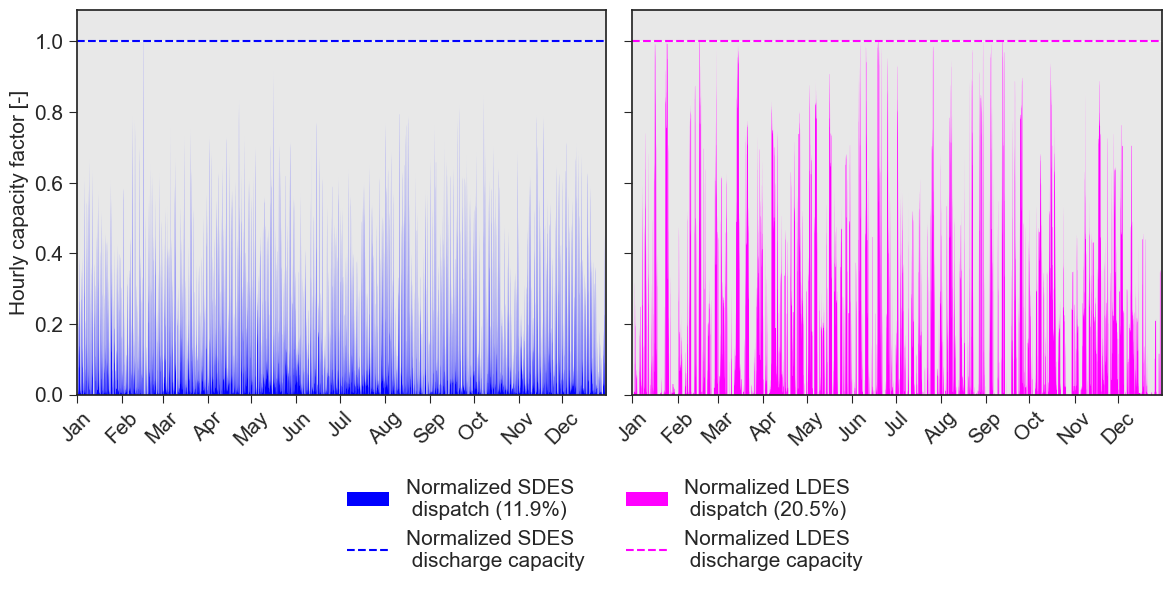

In [102]:
fig, ax = plt.subplots(1,2,figsize=(14,5),sharex=True,sharey=True)

# reduce distance between subplots
plt.subplots_adjust(wspace=0.05)

ax[0].fill_between(battery_dispatch_t.index, battery_dispatch_t/battery_capacity, 1, linewidth=0,color="lightgrey",alpha=0.5)
ax[0].fill_between(battery_dispatch_t.index, battery_dispatch_t/battery_capacity, linewidth=0, color="blue",alpha=1,label="Normalized SDES \n dispatch (" + str(round((battery_dispatch_t/battery_capacity).mean()*100,1)) + "%)")
ax[0].fill_between(battery_dispatch_t.index, 1, 100, linewidth=0,color="lightgrey",alpha=0.5)

ax[0].axhline(1,ls="--",color="blue",label="Normalized SDES \n discharge capacity")

ax[1].fill_between(LDES_dispatch_t.index, LDES_dispatch_t/LDES_capacity, 1, linewidth=0,color="lightgrey",alpha=0.5)
ax[1].fill_between(LDES_dispatch_t.index, LDES_dispatch_t/LDES_capacity, linewidth=0,color="magenta",alpha=1,label="Normalized LDES \n dispatch (" + str(round((LDES_dispatch_t/LDES_capacity).mean()*100,1)) + "%)")
ax[1].fill_between(LDES_dispatch_t.index, 1, 100, linewidth=0,color="lightgrey",alpha=0.5)

ax[1].axhline(1, ls="--",color="magenta",label="Normalized LDES \n discharge capacity")

ax[0].set_xlim(pd.Timestamp("1/1/2013"),pd.Timestamp("31/12/2013"))
ax[0].set_ylim(0,1.09)

# set legend in top right corner
fig.legend(bbox_to_anchor=(0.7,-0.02), frameon = False,prop={'size': fs},ncol=2)
# ax[1].legend(bbox_to_anchor=(0.7,0.865), frameon = False,prop={'size': fs})

ax[0].set_ylabel("Hourly capacity factor [-]")

# rotate xtick labels
for axi in ax:
    for tick in axi.get_xticklabels():
        tick.set_rotation(45)

# format xtick labels to show only month
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%b")
ax[1].xaxis.set_major_formatter(date_form)

fig.savefig("LDES_and_SDES_capacity_factors_w90_s10.png",
                bbox_inches="tight",
                dpi=300)

Number of cycles and the average depth of discharge:

In [87]:
# calculate number of cycles
def calculate_number_of_cycles(soc):
    ldes_soc = soc
    ldes_soc_norm = ldes_soc/ldes_soc.max()*100

    ldes_soc_diff = ldes_soc.diff()
    ldes_soc_diff[ldes_soc_diff < 0] = 0 # negative changes (discharging) get 0 values
    ldes_soc_diff[ldes_soc_diff > 0] = 1 # positive changes (charging) get 1 values
    ldes_soc_diff_diff = ldes_soc_diff.diff()

    # calculate average depth of discharge
    ldes_cycle_index_1 = ldes_soc_diff_diff[ldes_soc_diff_diff > 0].index
    ldes_cycle_index_2 = ldes_soc_diff_diff[ldes_soc_diff_diff < 0].index

    if len(ldes_cycle_index_2) > len(ldes_cycle_index_1):
        ldes_cycle_index_2 = ldes_cycle_index_2[:-1]
        
    elif len(ldes_cycle_index_2) < len(ldes_cycle_index_2):
        ldes_cycle_index_1 = ldes_cycle_index_1[:-1]
    
    DOD = ((ldes_soc.loc[ldes_cycle_index_2].values - ldes_soc.loc[ldes_cycle_index_1])/(ldes_soc.max())*100)

    # neglect cycles with DOD < 5% of the maximum SOC
    DOD = DOD[DOD >= 5]

    no_cycles = len(DOD)
    print("No. cycles: ",no_cycles)
    print("Avg. DOD: ", DOD.mean())

    fig,ax = plt.subplots(2,sharex=True, figsize=(14,5))
    ax[0].plot(ldes_soc_norm.index, ldes_soc_norm)
    ax[0].scatter(ldes_soc_norm.loc[DOD.index].index,ldes_soc_norm.loc[DOD.index],marker="o",color="r",s=15)
    ax[1].bar(DOD.index,DOD)
    ax[0].set_ylabel("State of charge [%]")
    ax[1].set_ylabel("Depth of discharge [%]")

    ax[0].set_xlim(pd.Timestamp("1/1/2013"),pd.Timestamp("31/12/2013"))
    ax[0].grid()
    ax[1].grid()

    return no_cycles, DOD, fig, ax

No. cycles:  99
Avg. DOD:  37.597467265973634


C:\Users\au485969\AppData\Local\Temp\ipykernel_7536\681518004.py:30: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



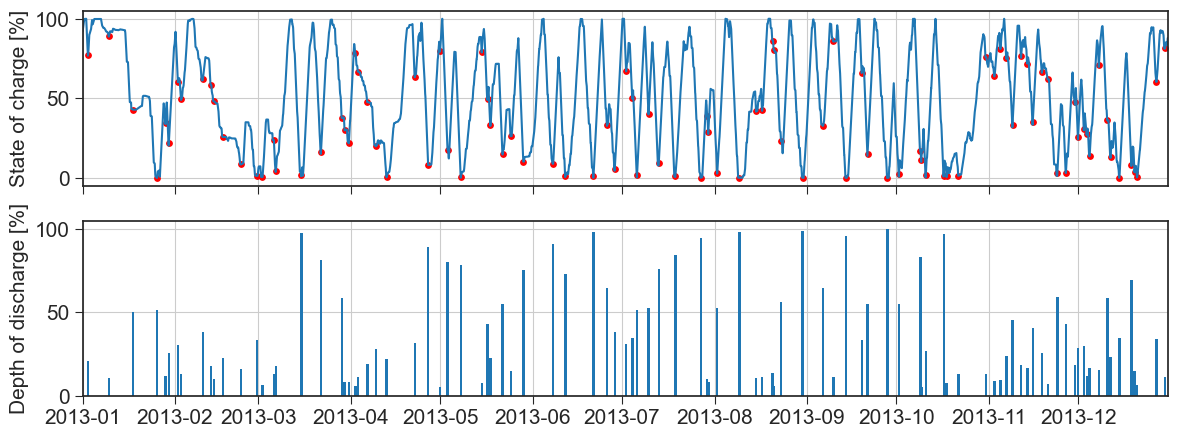

In [82]:
ldes_soc = n.stores_t.e[ldes_stores.index].sum(axis=1)

no_cycles, DOD, fig, ax = calculate_number_of_cycles(ldes_soc)

fig.savefig("LDES_DOD_and_NO_CYCLES.png",
                bbox_inches="tight",
                dpi=300)

In [83]:
# calculate delta time between cycles 
delta_time = DOD.index.to_series().diff().dt.total_seconds()/3600
delta_time.mean()

88.4795918367347

In [88]:
sdes_soc = n.stores_t.e[battery_stores.index].sum(axis=1)

no_cycles, DOD, fig, ax = calculate_number_of_cycles(sdes_soc)

fig.savefig("SDES_DOD_and_NO_CYCLES.png",
                bbox_inches="tight",
                dpi=300)


ValueError: operands could not be broadcast together with shapes (664,) (665,) 

In [399]:
# calculate delta time between cycles 
delta_time = DOD.index.to_series().diff().dt.total_seconds()/3600
delta_time.mean()

15.910746812386156

# Check demand

In [27]:
links_wo_transmission = n.links.drop(n.links.query("carrier == 'DC'").index)
electricity_buses = list(n.buses.query('carrier == "AC"').index) + list(
    n.buses.query('carrier == "low voltage"').index
)
boolean_elec_demand_via_links = [
    links_wo_transmission.bus0[i] in electricity_buses
    for i in range(len(links_wo_transmission.bus0))
]
boolean_elec_demand_via_links_series = pd.Series(boolean_elec_demand_via_links)
elec_demand_via_links = links_wo_transmission.iloc[
    boolean_elec_demand_via_links_series[boolean_elec_demand_via_links_series].index
]

# Drop batteries
elec_demand_via_links = elec_demand_via_links.drop(
    elec_demand_via_links.index[elec_demand_via_links.index.str.contains("battery")]
)

# Drop LDES
elec_demand_via_links = elec_demand_via_links.drop(
    elec_demand_via_links.index[elec_demand_via_links.index.str.contains("LDES")]
)

# Drop distribution links
elec_demand_via_links = elec_demand_via_links.drop(
    elec_demand_via_links.index[
        elec_demand_via_links.index.str.contains("distribution")
    ]
)

endogenous_demand = n.links_t.p0[elec_demand_via_links.index]

In [28]:
endogenous_demand

Link,AL0 0 H2 Electrolysis,AT0 0 H2 Electrolysis,BA0 0 H2 Electrolysis,BE0 0 H2 Electrolysis,BG0 0 H2 Electrolysis,CH0 0 H2 Electrolysis,CZ0 0 H2 Electrolysis,DE0 0 H2 Electrolysis,DK0 0 H2 Electrolysis,DK1 0 H2 Electrolysis,...,MK0 0 helmeth,NL0 0 helmeth,NO1 0 helmeth,PL0 0 helmeth,PT0 0 helmeth,RO0 0 helmeth,RS0 0 helmeth,SE1 0 helmeth,SI0 0 helmeth,SK0 0 helmeth
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.000642,0.005621,0.000921,0.007280,0.000407,0.005297,0.005117,19337.202379,1258.220849,2328.236743,...,0.000381,0.001055,0.001088,0.000995,0.000794,0.000283,0.000405,0.001108,0.000568,0.000905
2013-01-01 01:00:00,0.000687,0.005589,0.001113,0.007269,0.000412,0.005432,0.005193,19337.202028,1261.284349,2420.679340,...,0.000401,0.001055,0.001088,0.000995,0.000794,0.000285,0.000430,0.001108,0.000660,0.000905
2013-01-01 02:00:00,0.001748,0.005560,0.002669,0.007256,0.001017,0.005530,0.005260,19337.201768,1234.342332,2483.907931,...,0.000600,0.001055,0.001088,0.000995,0.000800,0.000492,0.000622,0.001108,0.000741,0.000904
2013-01-01 03:00:00,0.004412,0.005537,0.004151,0.007248,0.004375,0.005509,0.005245,19337.201642,1203.623996,2531.831617,...,0.000766,0.001055,0.001088,0.000995,0.000800,0.000768,0.000766,0.001108,0.000741,0.000904
2013-01-01 04:00:00,0.004242,0.005518,0.004020,0.007246,0.004138,0.005507,0.005230,19337.201558,1153.583948,2538.977728,...,0.000766,0.001056,0.001088,0.000995,0.000800,0.000768,0.000766,0.001108,0.000741,0.000904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,0.000528,0.004238,0.000629,0.007342,0.000412,0.004620,0.002873,19337.203512,1049.793146,2120.427456,...,0.000365,0.001145,0.001182,0.001080,0.000877,0.000306,0.000376,0.001205,0.000475,0.000976
2013-12-31 20:00:00,0.000538,0.004167,0.000649,0.007330,0.000421,0.004633,0.002829,19337.203437,1087.498608,2167.687043,...,0.000371,0.001145,0.001182,0.001079,0.000877,0.000306,0.000384,0.001205,0.000491,0.000976
2013-12-31 21:00:00,0.000532,0.004128,0.000641,0.007314,0.000424,0.004593,0.002783,19337.203377,1078.211325,2243.158222,...,0.000370,0.001145,0.001182,0.001079,0.000877,0.000306,0.000383,0.001205,0.000491,0.000976


In [ ]:
exogenous_demand = (n.loads_t.p_set[n.loads.query("carrier == 'electricity'").index].sum().sum() + 
                    (n.loads.query("carrier == 'industry electricity'").p_set*len(n.snapshots)).sum()
                    )
endogenous_demand = calculate_endogenous_demand(n)
total_demand_j = exogenous_demand + endogenous_demand.sum().sum()